<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter09/Semantic_Segmentation_with_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation
The goal is to label each and every pixel in the image.
There are 2 types of segmentation:
1. semantic segmentation
1. instance segmentation

the following figure illustrates the difference between the 2, in the bottom 2 figures (its taken from the [coco paper](https://arxiv.org/pdf/1405.0312.pdf)):
![coco](unet_1.png)

# U-Net for semantic segmentation
when we had to do image classification or object detection, the output was a single or list of labels - i.e. not at the same shape of the input. the local structure information of the pixels was transformed to other structure (label, bounding boxes etc.) so we could flatten the image and do the prediction in the classification heads.

in the case of image segmentation, where the output shape is the same as that of the input image's shape, flattening the convolutions' outputs and then reconstructing the image might result in a loss of information. 
Furthermore, the contours and shapes present in the original image will not vary in the output image in the case of image segmentation, so the networks we have dealt with so far (which flatten the last layer and connect additional dense layers) are not optimal when we are performing segmentation.

we might want to use fully convolutional architecture so that we dont have to flatten the image.  
The U-Net architecture helps us achieve this. A typical representation of U-Net is as follows (the input image is of the shape 3 x 96 x 128, while the number of classes present in the image is 21; this means that the output contains 21 channels):
![unet_arch](unet_2.png)

Note that in the left wing of the U we're decimating the image (downscaling) and in the right wing we're upscaling back to the original resolution. there are also skip connections represented by the 'torch-cat' arrows.

This way, the U-Net architecture learns to preserve the structure (and shapes of objects) of the original image while leveraging the convolution's features to predict the classes that correspond to each pixel.  
In general, we have as many channels in the output as the number of classes we want to predict.

## Performing Upscaling
In the U-Net architecture, upscaling is performed using the `nn.ConvTranspose2d` method, which takes the number of input channels, the number of output channels, the kernel size, and stride as input parameters. An example calculation for `ConvTranspose2d` is as follows:
![conv2dtrans](unet_3.png)  

In the preceding example, we took an input array of shape 3 x 3 (Input array), applied a stride of 2 where we distributed the input values to accommodate the stride (Input array adjusted for stride), padded the array with zeros (Input array adjusted for stride and padding), and convolved the padded input with a filter (Filter/Kernel) to fetch the output array



In [1]:
import torch
import torch.nn as nn

In [21]:
m = nn.ConvTranspose2d(1,1,kernel_size=(2,2),stride=2,padding=0)
m.weight = torch.nn.Parameter(torch.ones(1,1,2,2))
print(m.weight.shape)

torch.Size([1, 1, 2, 2])


note that internally, padding is calculated as dilation\*(kernel_size-1)-padding  
The dilation is defaulted to 1 so we get : 1 \* (2-1)-0 = 1 so we add a zero padding of 1 to both dimensions of input array


In [22]:
inp=torch.ones(1,1,3,3) # as if its 1 image with 1 channel of size 3x3
print(inp.shape)
out=m(inp)
print(out.shape)

torch.Size([1, 1, 3, 3])
torch.Size([1, 1, 4, 4])


In [23]:
out

tensor([[[[1.0199, 1.0199, 1.0199, 1.0199],
          [1.0199, 1.0199, 1.0199, 1.0199],
          [1.0199, 1.0199, 1.0199, 1.0199],
          [1.0199, 1.0199, 1.0199, 1.0199]]]],
       grad_fn=<SlowConvTranspose2DBackward0>)

<font color='red'> Note that in the figure above we got 6x5 whereas here the output is 6x6. also, we couldnt reprduce the values of the output (ones(6,6)) </font>

## Implementing semantic segmentation using U-Net
we'll leverage the U-Net architecture to predict the class that corresponds to all the pixels in the image. A sample of such an input-output combination is as follows:
![unet_sample](unet_4.png)  
in the preceding picture, the objects that belong to the same class (in the left image – the input image) have the same pixel value (in the right image – the output image), which is why we are **segmenting** the pixels that are **semantically** similar to each other. This is also known as semantic segmentation.

In [24]:
import os
if not os.path.exists('dataset1'):
    !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
    !unzip -q dataset1.zip
    !rm dataset1.zip
#     !pip install -q torch_snippets pytorch_model_summary

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Defining the dataset

In [25]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

In [30]:
class SegData(Dataset):
    def __init__(self, split):
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split
    def __len__(self):
        return len(self.items)
    def __getitem__(self, ix):
        image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224,224))
        mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png')
        mask = cv2.resize(mask, (224,224))
        return image, mask
    def choose(self): return self[randint(len(self))]
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

Note that the mask images contain integers that range between [0,11]. This indicates that there are 12 different classes.  
The function `choose` for selecting a random image index is mainly for debugging purposes

In [31]:
trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

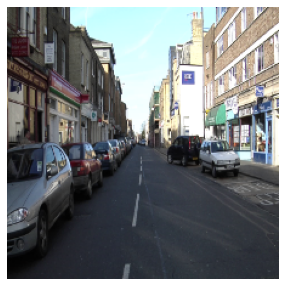

In [34]:
show(trn_ds[10][0])

### Define the neural network model


In [35]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [36]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [37]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

note that for the left wing of the U-net we're using pretrained layers from vgg16 model

### Loss function

In [38]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

### train and validate (on batch) functions


In [39]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)  # predicted masks
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks) 
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

### create model instance

In [40]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

### Train the model

In [41]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

EPOCH: 1.000	trn_loss: 1.214	trn_acc: 0.743	val_loss: 0.889	val_acc: 0.826	(14.42s - 274.03s remaining)
EPOCH: 2.000	trn_loss: 0.705	trn_acc: 0.827	val_loss: 0.638	val_acc: 0.837	(28.80s - 259.16s remaining)
EPOCH: 3.000	trn_loss: 0.567	trn_acc: 0.851	val_loss: 0.692	val_acc: 0.809	(43.23s - 244.99s remaining)
EPOCH: 4.000	trn_loss: 0.519	trn_acc: 0.860	val_loss: 0.499	val_acc: 0.866	(57.72s - 230.89s remaining)
EPOCH: 5.000	trn_loss: 0.474	trn_acc: 0.870	val_loss: 0.635	val_acc: 0.814	(72.24s - 216.71s remaining)
EPOCH: 6.000	trn_loss: 0.445	trn_acc: 0.877	val_loss: 0.492	val_acc: 0.865	(86.76s - 202.43s remaining)
EPOCH: 7.000	trn_loss: 0.400	trn_acc: 0.888	val_loss: 0.482	val_acc: 0.856	(101.71s - 188.90s remaining)
EPOCH: 8.000	trn_loss: 0.370	trn_acc: 0.896	val_loss: 0.391	val_acc: 0.888	(116.57s - 174.86s remaining)
EPOCH: 9.000	trn_loss: 0.355	trn_acc: 0.900	val_loss: 0.396	val_acc: 0.883	(131.40s - 160.60s remaining)
EPOCH: 10.000	trn_loss: 0.330	trn_acc: 0.907	val_loss: 0.570	

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:00<00:00, 2175.61it/s]


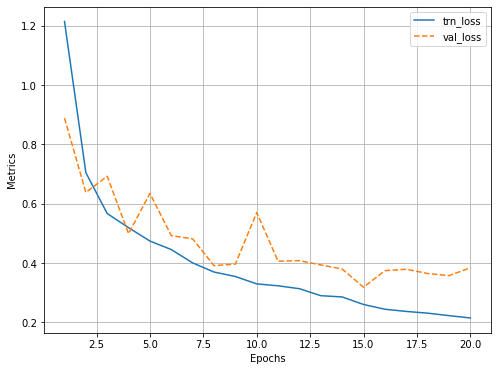

In [43]:
log.plot_epochs(['trn_loss','val_loss'])

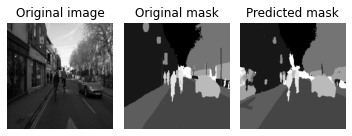

In [44]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])

# Possible exercises
- can it be further improved with more epochs ?  
    it looks like the validation loss had stabilized. so without further tuning of learning rate or other hyper parameters, just adding epochs will probably not help

- what about other losses ? can we try the FocalLoss ? what is the loss from the original UNet paper ?  
    The originl UNet didnt specify a loss. probably the regular cross entropy.  
    The Focal Loss is in case of class imbalance  
    
    